In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
from glob import glob
from typing import *
sys.path.append('../../')
from fastprogress import progress_bar
from modules.basics import *

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize, Optimizer
from modules.plotting import *

In [4]:
experiment = Experiment.from_json(str(RESULTS_PATH/'17_hyperparam_search_mbp.json'))
for m in ['helios_cuda', 'icarus', 'daedalus', 'morpheus', 'lipml']:
    e = Experiment.from_json(str(RESULTS_PATH/f'17_hyperparam_search_{m}.json'))
    print(f'Machine {m} with {len(e["scores"])}')
    experiment['scores'] += e['scores']
    experiment['params'] += e['params']    
len(experiment['scores'])

2

In [5]:
def proc_params(params:Dict[str,Any]) -> List[Any]:
    ps = [params['depth'], params['do'], params['wd'], params['width'], params['growth_rate']]
    return ps

In [6]:
def proc_results(results:Dict[str,Any], val:bool=True) -> float:
    return results['val'] if val else results['test'][0]

In [7]:
def get_min(x) -> float:
    print(x)
    return 0

In [12]:
def get_model_builder(params:Dict[str,Union[int,float]]) -> ModelBuilder:
    body = partial(FullyConnected, depth=params['depth'], width=params['width'], act='swish',
                   dense=True, growth_rate=params['growth_rate'], do=params['do'])
    cat_embedder = CatEmbedder.from_fy(train_fy, emb_szs=[3])
    opt_args = {'opt':'adam', 'eps':1e-8, 'weight_decay':params['wd']}
    return ModelBuilder(objective='classification', cont_feats=train_fy.cont_feats, n_out=1, cat_embedder=cat_embedder,
                        opt_args=opt_args, body=body)

In [13]:
train_fy = HEPAugFoldYielder(DATA_PATH/'train.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [14]:
z0 = []
for x in progress_bar(experiment['params']):
    m = Model(get_model_builder(x))
    z0.append(m.get_param_count())

In [15]:
df = pd.DataFrame({'MVAC': [s['val']     for s in experiment['scores']],
                   'MAPA': [s['test'][0] for s in experiment['scores']],
                   'MAPA_unc': [s['test'][1] for s in experiment['scores']],
                   'Size': z0})
df.sort_values('Size', inplace=True)
df = df[df.Size <= 100000]

In [16]:
def plot_scores_by_complexity(df, savename:Optional[str]=None, settings:PlotSettings=plot_settings) -> None:
    with sns.axes_style(settings.style), sns.color_palette(settings.cat_palette) as palette:
        plt.figure(figsize=(settings.w_mid, settings.h_mid))
        sns.regplot('Size', 'MVAC', data=df, label='MVAC')
        sns.regplot('Size', 'MAPA', data=df, label='MAPA')
        plt.legend(loc=settings.leg_loc, fontsize=settings.leg_sz)
        plt.xlabel('Number of parameters', fontsize=settings.lbl_sz, color=settings.lbl_col)
        plt.ylabel('Metric', fontsize=settings.lbl_sz, color=settings.lbl_col)
        plt.xticks(fontsize=settings.tk_sz, color=settings.tk_col)
        plt.yticks(fontsize=settings.tk_sz, color=settings.tk_col)
        plt.title(settings.title, fontsize=settings.title_sz, color=settings.title_col, loc=settings.title_loc)
        if savename is not None: plt.savefig(settings.savepath/f'{savename}{settings.format}', bbox_inches='tight')
        plt.show()  

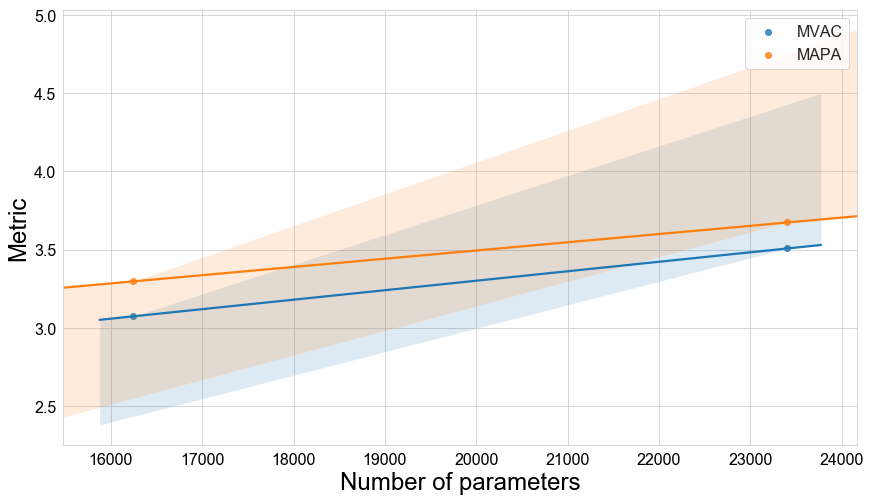

In [17]:
plot_scores_by_complexity(df, savename='complexity')

# Validation

In [18]:
x0 = [proc_params(x) for x in experiment['params']]
y0 = [-proc_results(x) for x in experiment['scores']]

In [19]:
len(x0), len(y0)

(2, 2)

In [21]:
arr = np.array(x0)
space  = [Integer(arr[:,0].min(), arr[:,0].max(), name='depth'),
          Real(arr[:,1].min(), arr[:,1].max(), name='do'),
          Real(arr[:,2].min(), arr[:,2].max(), name='wd'),
          Integer(arr[:,3].min(), arr[:,3].max(), name='width'),
          Real(arr[:,4].min(), arr[:,4].max(), name='growth_rate')]

In [22]:
opt = gp_minimize(lambda x: 0, space, n_random_starts=0, x0=x0, y0=y0, n_calls=0, verbose=1, random_state=0);

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.2376
Function value obtained: -3.0738
Current minimum: -3.5077


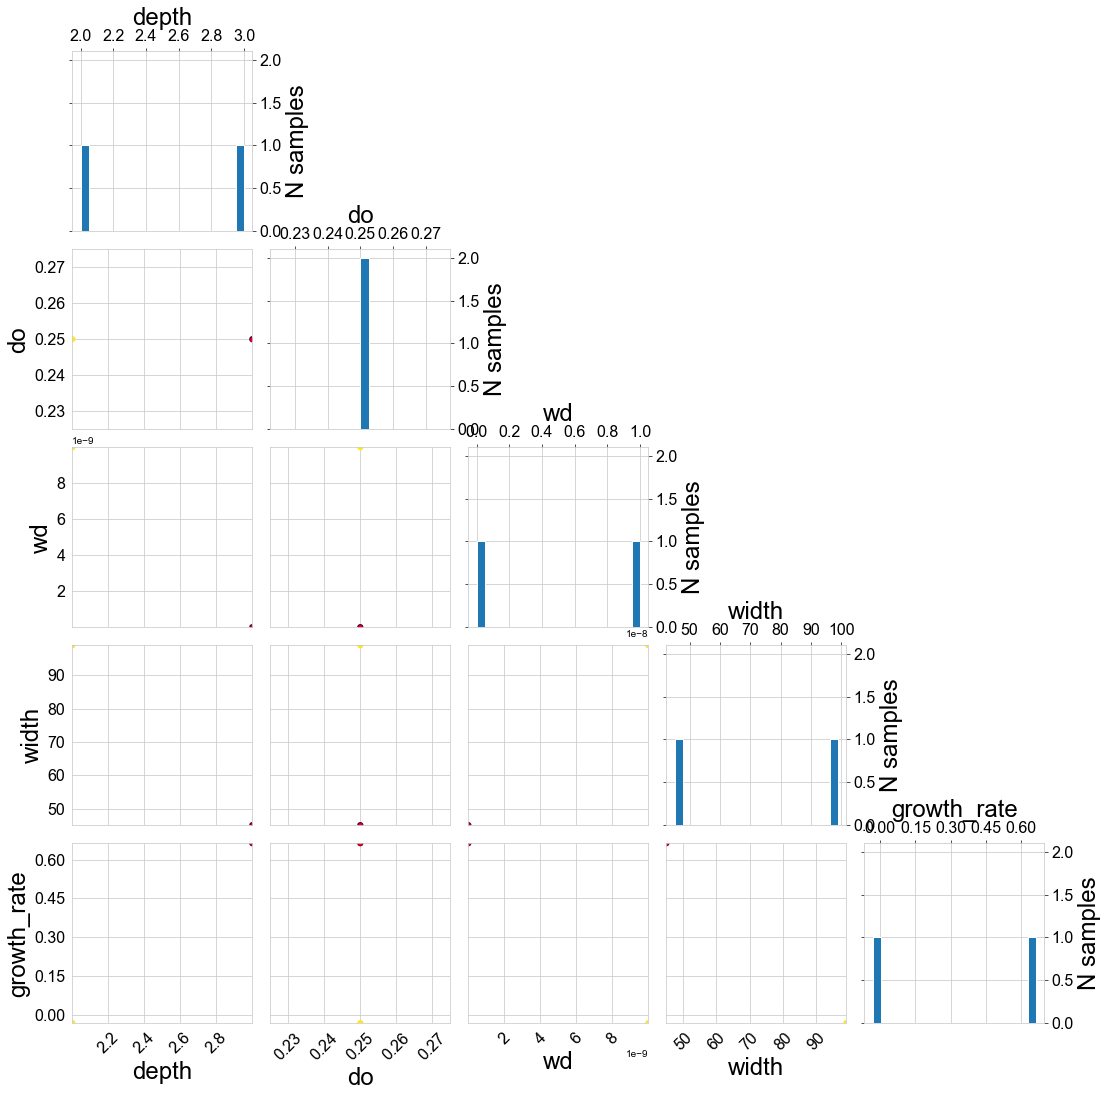

In [23]:
_ = plot_evaluations(opt, dimensions=['depth', 'do', 'wd', 'width', 'growth_rate'], settings=plot_settings, savename='arch_opt_2_evals')

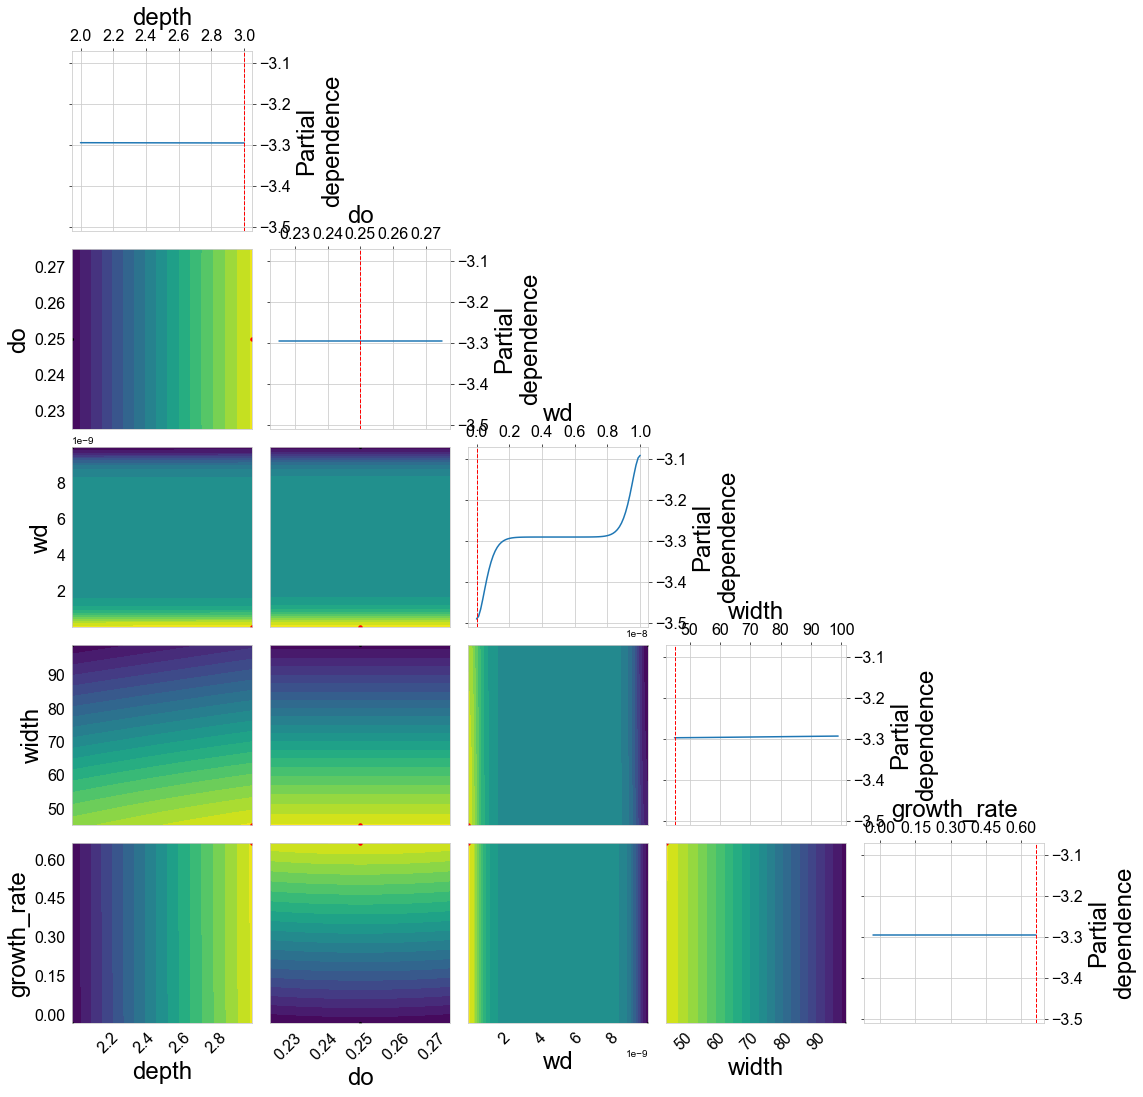

In [24]:
_ = plot_objective(opt, dimensions=['depth', 'do', 'wd', 'width', 'growth_rate'], size=3, levels=20, n_points=80,
                   settings=plot_settings, savename='arch_opt_2_val')

In [25]:
opt.x, opt.fun

([3, 0.25, 0.0, 45, 0.6640794721039245], -3.5077060739605166)

### Test

In [27]:
x0 = [proc_params(x) for x in experiment['params']]
y0 = [-proc_results(x, False) for x in experiment['scores']]

In [28]:
len(x0), len(y0)

(2, 2)

In [29]:
opt = gp_minimize(lambda x: 0, space, n_random_starts=0, x0=x0, y0=y0, n_calls=0, verbose=1, random_state=0);

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.2389
Function value obtained: -3.2971
Current minimum: -3.6736


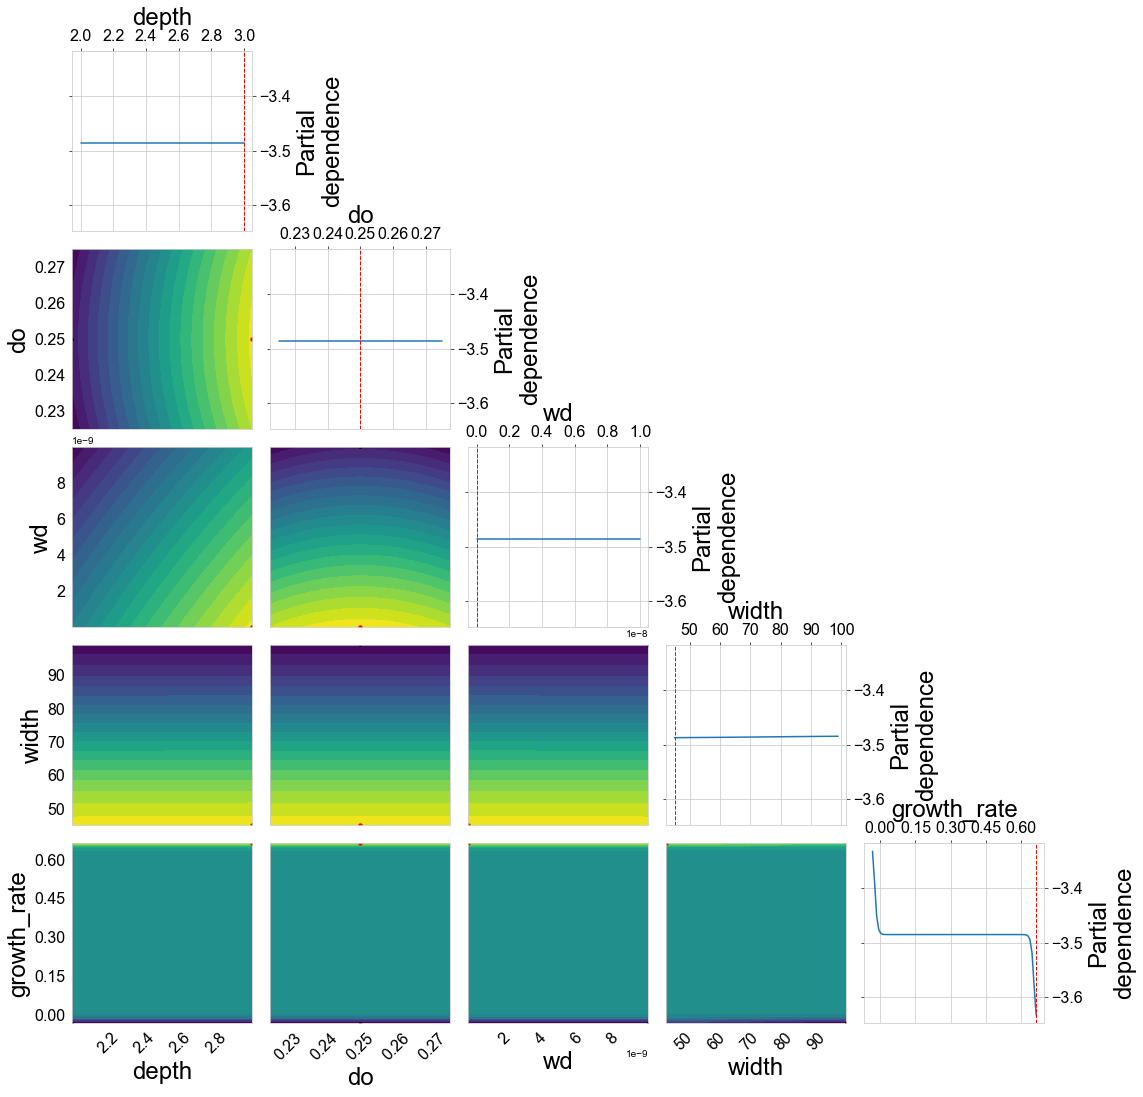

In [30]:
_ = plot_objective(opt, dimensions=['depth', 'do', 'wd', 'width', 'growth_rate'], size=3, levels=20, n_points=80,
                   settings=plot_settings, savename='arch_opt_2_test')

In [31]:
opt.x, opt.fun

([3, 0.25, 0.0, 45, 0.6640794721039245], -3.6736365380806335)